In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv
/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv
/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv


In [3]:
import pandas as pd
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
import glob
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from time import time 
from collections import defaultdict

In [4]:
#turn on internet option in kernel
!pip install bangla-stemmer

In [5]:
from bangla_stemmer.stemmer import stemmer

In [6]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out


def Stemming(text):
    
    x=str(text)
    l=x.split()

    stmr = stemmer.BanglaStemmer()
    stm = stmr.stem(l)

    out=' '.join(stm)
    
    return str(out)

In [8]:
df =pd.read_csv('/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv')

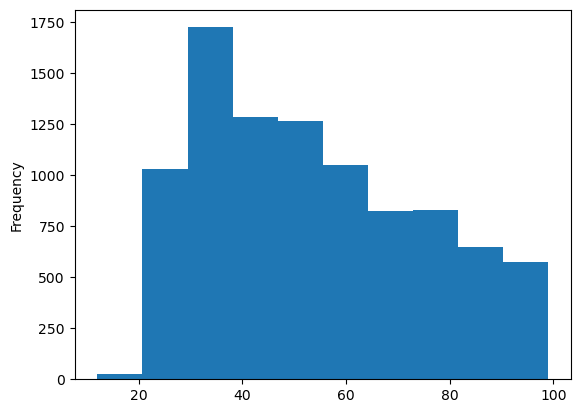

In [9]:
df = df[(df['Data'].str.len()<100)&(df['Data'].str.len()>1)]
df['Data'].apply(lambda x: len(str(x))).plot(kind='hist');

In [11]:
df['Data'] = df.Data.apply(lambda x: preprocessing(str(x)))

In [ ]:
df['Data'] = df.Data.apply(lambda x: stopwordRemoval(str(x)))

In [114]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def numerals_normalize( df ):

  for i in range(len(df)):
    words = df['Data'][i].split()
    st = ''
    for word in words:
      if(st != ''):
        st += ' '
      if(word[0]>='0' and word[0] <='9' and word[-1]>='0' and word[-1] <='9'):
        st += "CC"
      else:
        st += word
    df['Data'][i] = st

  return df


df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv")
df_train = numerals_normalize( df_train )

df_val = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv")
df_val = numerals_normalize( df_val )

df_test = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv")
df_test = numerals_normalize( df_test )


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [115]:
df_test

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1
...,...,...
1581,ঐ পুলিশ কুওারবাচচাদের গুলিকরে মেরে ফেলা উচিত,2
1582,খিচুড়ি পর্ব মারাত্মক । বাকি টা দেখি তারপর কমেন্ট,1
1583,পাশের ফ্রেন্ডটা কি ছেলে না মেয়ে,2
1584,মদ লকমান না খেলেও আমরা খাই এমনটাই মনে হচ্ছে,2


In [116]:
print("Total number of reviews in Train Data: {} ".format(len(df_train)))

Total number of reviews in Train Data: 12575 


In [117]:
df_train.isnull().sum()

Data     0
Label    0
dtype: int64

In [118]:
df_train

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
...,...,...
12570,বর্ডারে অনেক লেট হয়ে যাওয়াতে আমরা জিপে করে চলে...,1
12571,আমার সোনার বাংলাতে এমন রক্ষক নামের ভক্ষকের কোন...,2
12572,ওনারা এত হাইজিনিক ও এত সুন্দর পরিবেশে রান্না ক...,1
12573,বাংলাদেশ আমরা পুলিশ চাই না এই ধরনে পুলিশ দরকার...,2


In [134]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import gensim
from sklearn.metrics import accuracy_score

In [120]:
 def transform(data):

    # determine the dimensionality of vectors
    v = self.word_vectors.get_word_vector('আমি')
    D = v.shape[0]

    X = np.zeros((len(data), D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = word_vectors.get_word_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

In [135]:
X_train = df_train["Data"]
X_test = df_test["Data"]

y_train = df_train["Label"]
y_test = df_test["Label"]

tfidf_vect_ngram = TfidfVectorizer(analyzer = "word", ngram_range=(3,3), tokenizer=lambda x: x.split())
tfidf_vect_ngram.fit(X_train)
#feature_names = tfidf_vect_ngram.get_feature_names()
xtrain =  tfidf_vect_ngram.transform(X_train) 
xtest = tfidf_vect_ngram.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [136]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [87]:
linear = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(xtrain, y_train)
rbf = SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(xtrain, y_train)
poly = SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(xtrain, y_train)
sig = SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(xtrain, y_train)

In [90]:
linear_pred = linear.predict(xtest)
poly_pred = poly.predict(xtest)
rbf_pred = rbf.predict(xtest)
sig_pred = sig.predict(xtest)

In [91]:
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(xtest, y_test)
accuracy_poly = poly.score(xtest, y_test)
accuracy_rbf = rbf.score(xtest, y_test)
accuracy_sig = sig.score(xtest, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.6765447667087011
Accuracy Polynomial Kernel: 0.5586380832282472
Accuracy Radial Basis Kernel: 0.6639344262295082
Accuracy Sigmoid Kernel: 0.6771752837326608


In [137]:
from sklearn.svm import LinearSVC
linear = LinearSVC(C = 10, penalty='l2', loss = 'squared_hinge')
linear.fit(xtrain, y_train)
pred = linear.predict(xtest)

In [138]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)

In [142]:
cm

array([[ 87, 234,  40],
       [ 37, 578,  39],
       [ 25, 261, 285]])

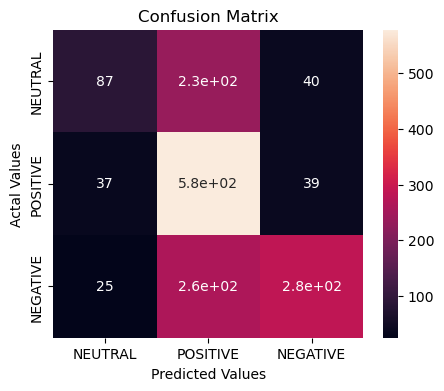

In [139]:
  cm_df = pd.DataFrame(cm,
                     index = ['NEUTRAL','POSITIVE','NEGATIVE'], 
                     columns =['NEUTRAL','POSITIVE','NEGATIVE'])
    
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

In [140]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


# Calculate precision, recall, and f1-score from the confusion matrix
precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.6369192384120141
Recall: 0.5989911727616646
F1-score: 0.5731577484054313


In [141]:
print('Accuracy: %.3f' % accuracy_score(y_test,pred))

Accuracy: 0.599


For unigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


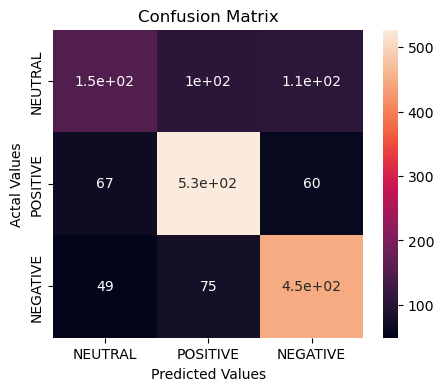

Precision:  56.7
Recall:  70.93
F1 score:  63.03
Accuracy: 0.709
For Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


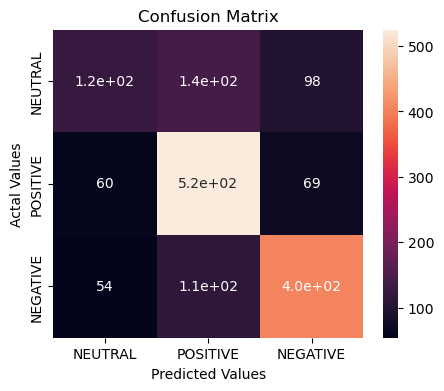

Precision:  54.36
Recall:  66.39
F1 score:  59.78
Accuracy: 0.664
For Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


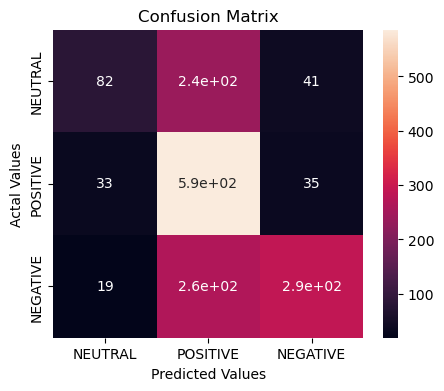

Precision:  51.51
Recall:  60.21
F1 score:  55.52
Accuracy: 0.602
For Unigram+Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


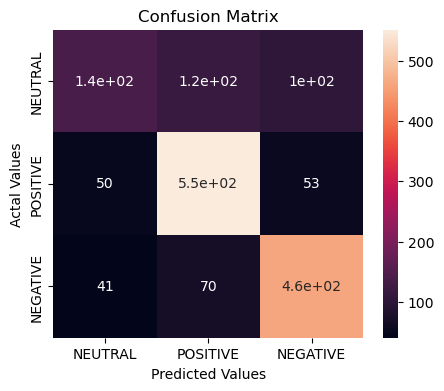

Precision:  57.41
Recall:  72.57
F1 score:  64.1
Accuracy: 0.726
For Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


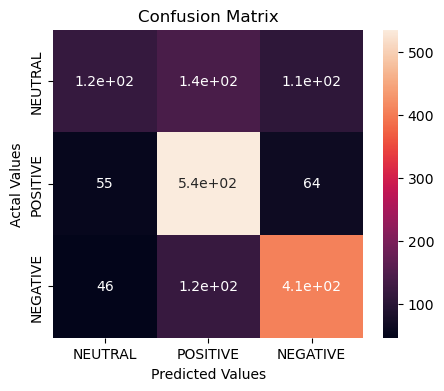

Precision:  54.29
Recall:  66.65
F1 score:  59.84
Accuracy: 0.666
For Unigram+Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


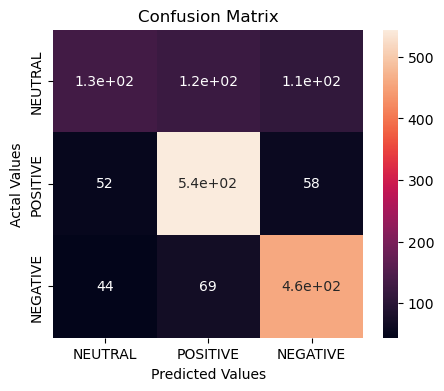

Precision:  56.65
Recall:  71.44
F1 score:  63.19
Accuracy: 0.714
Char 2-gram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


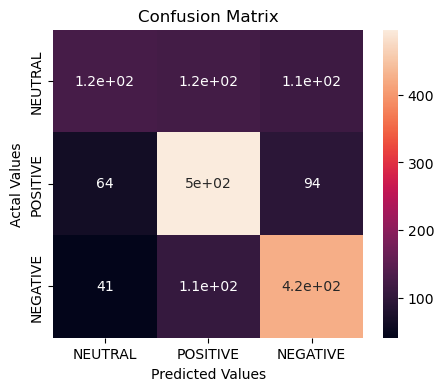

Precision:  53.07
Recall:  65.89
F1 score:  58.79
Accuracy: 0.659
Char 3-gram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


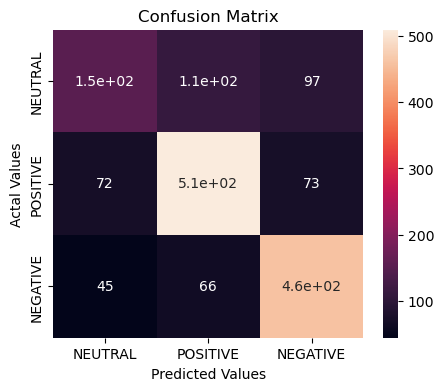

Precision:  56.07
Recall:  70.74
F1 score:  62.56
Accuracy: 0.707
Char 4-gram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


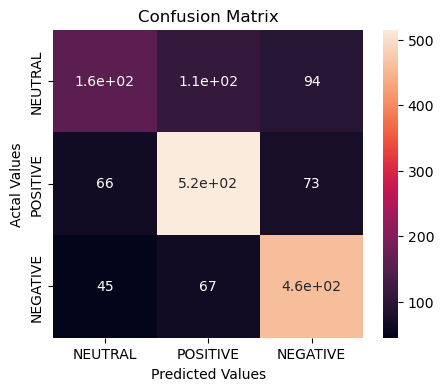

Precision:  56.55
Recall:  71.31
F1 score:  63.08
Accuracy: 0.713
Char 5-gram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


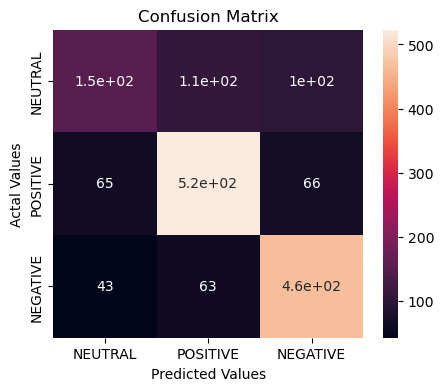

Precision:  56.82
Recall:  71.94
F1 score:  63.49
Accuracy: 0.719
C2+C3:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


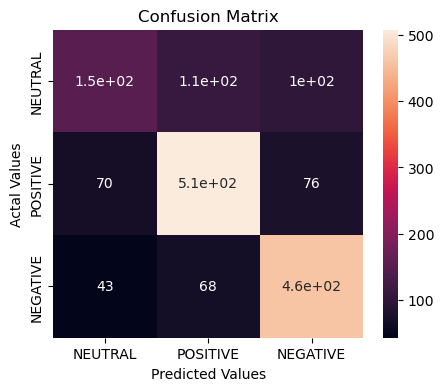

Precision:  55.77
Recall:  70.43
F1 score:  62.25
Accuracy: 0.704
C3+C4:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


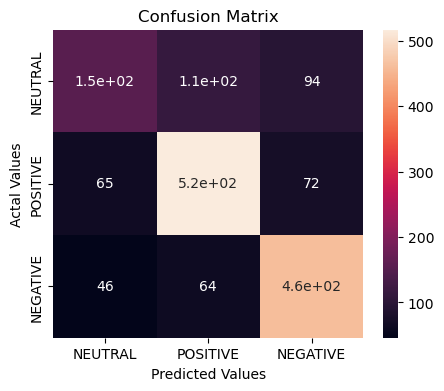

Precision:  56.57
Recall:  71.37
F1 score:  63.12
Accuracy: 0.714
C4+C5:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


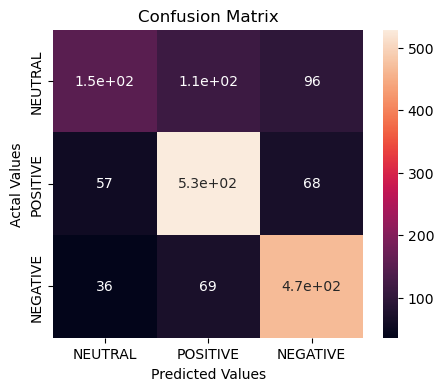

Precision:  56.85
Recall:  72.26
F1 score:  63.63
Accuracy: 0.723
C2+C3+C4:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


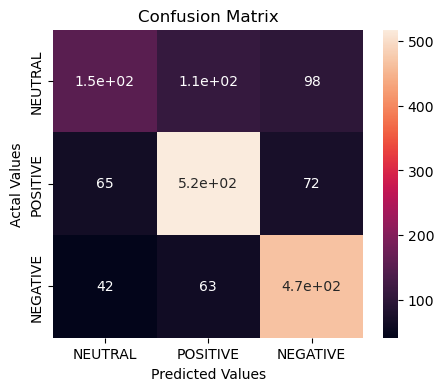

Precision:  56.52
Recall:  71.63
F1 score:  63.18
Accuracy: 0.716
C3+C4+C5:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


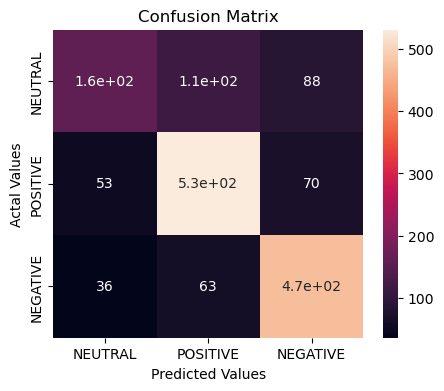

Precision:  57.47
Recall:  73.27
F1 score:  64.41
Accuracy: 0.733
C2+C3+C4+C5:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:552: UserWarning: The parameter 'tokenizer' will not be used since 'analyzer' != 'word'
  "The parameter 'tokenizer' will not be used"


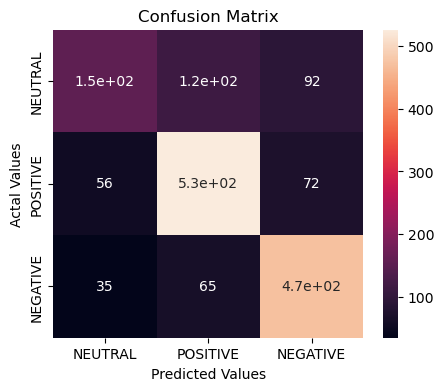

Precision:  56.92
Recall:  72.57
F1 score:  63.8
Accuracy: 0.726


In [17]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import gensim
from sklearn.metrics import accuracy_score
  
def RecallPrecisionFScore( y_test, pred ):

  arr = confusion_matrix(y_test, pred)

  fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
  fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
  tp = arr[0][0] + arr[1][1] + arr[2][2]
  
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*precision*recall )/(precision+recall) 

  print( "Precision: ", float('{0:.2f}'.format(precision*100)) )
  print( "Recall: ", float('{0:.2f}'.format(recall*100)) )
  print( "F1 score: ", float('{0:.2f}'.format(f1*100)) )

  return float('{0:.2f}'.format(precision*100)), float('{0:.2f}'.format(recall*100)), float('{0:.2f}'.format(f1*100))

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):

    # determine the dimensionality of vectors
    v = self.word_vectors.get_word_vector('আমি')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_word_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

def feature_based( df_train, df_test, c, x1, y1, gram ):

  X_train = df_train["Data"]
  X_test = df_test["Data"]

  y_train = df_train["Label"]
  y_test = df_test["Label"]

  tfidf_vect_ngram = TfidfVectorizer(analyzer = gram, ngram_range=(x1,y1), tokenizer=lambda x: x.split())
  tfidf_vect_ngram.fit(X_train)
  #feature_names = tfidf_vect_ngram.get_feature_names()
  xtrain =  tfidf_vect_ngram.transform(X_train) 
  xtest =  tfidf_vect_ngram.transform(X_test)

  linear = LinearSVC(C = c, penalty='l2', loss = 'squared_hinge')
  linear.fit(xtrain, y_train)

  pred = linear.predict(xtest)

  arr = confusion_matrix(y_test, pred)
  cm_df = pd.DataFrame(arr,
                     index = ['NEUTRAL','POSITIVE','NEGATIVE'], 
                     columns =['NEUTRAL','POSITIVE','NEGATIVE'])
    
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  RecallPrecisionFScore( y_test, pred )
  print('Accuracy: %.3f' % accuracy_score(y_test,pred))
  

if __name__ == '__main__':
 df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv" )
  df_val =  pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv" )
  df_test = pd.read_csv( "/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv" )
  print("For unigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 1, gram = "word" )
  print("For Bigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 2, gram = "word" )
  print("For Trigram:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 3, gram = "word" )
  print("For Unigram+Bigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 2, gram = "word" )
  print("For Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 3, gram = "word" )
  print("For Unigram+Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 1, y1 = 3, gram = "word" )
  print("Char 2-gram:")
  feature_based(df_train, df_test, c = 1, x1 = 2, y1 = 2, gram = "char" )
  print("Char 3-gram:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 3, gram = "char" )
  print("Char 4-gram:")
  feature_based(df_train, df_test, c = 1, x1 = 4, y1 = 4, gram = "char" )
  print("Char 5-gram:")
  feature_based(df_train, df_test, c = 1, x1 = 5, y1 = 5, gram = "char" )
  print("C2+C3:")
  feature_based(df_train, df_test, c = 1, x1 = 2, y1 = 3, gram = "char" )
  print("C3+C4:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 4, gram = "char" )
  print("C4+C5:")
  feature_based(df_train, df_test, c = 1, x1 = 4, y1 = 5, gram = "char" )
  print("C2+C3+C4:")
  feature_based(df_train, df_test, c = 1, x1 = 2, y1 = 4, gram = "char" )
  print("C3+C4+C5:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 5, gram = "char" )
  print("C2+C3+C4+C5:")
  feature_based(df_train, df_test, c = 1, x1 = 2, y1 = 5, gram = "char" )

For unigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


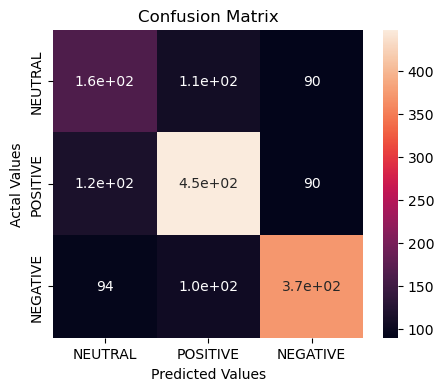

Precision:  52.79
Recall:  62.04
F1 score:  57.04
Accuracy: 0.620
For Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


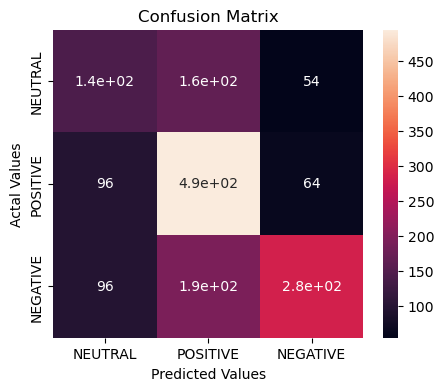

Precision:  51.83
Recall:  57.94
F1 score:  54.72
Accuracy: 0.579
For Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


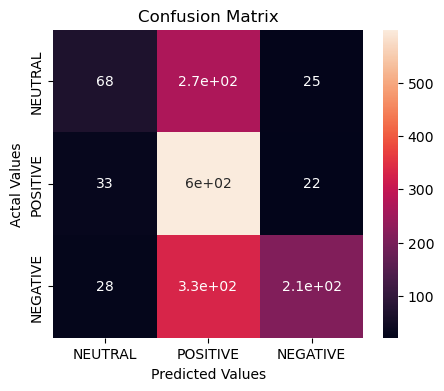

Precision:  49.63
Recall:  55.36
F1 score:  52.34
Accuracy: 0.554
For Unigram+Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


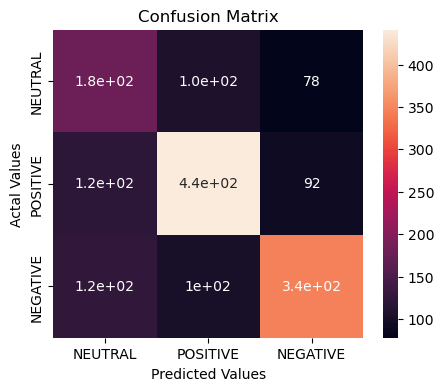

Precision:  53.38
Recall:  60.78
F1 score:  56.84
Accuracy: 0.608
For Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


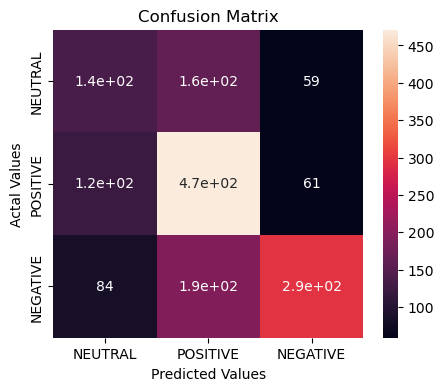

Precision:  50.33
Recall:  57.0
F1 score:  53.46
Accuracy: 0.570
For Unigram+Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


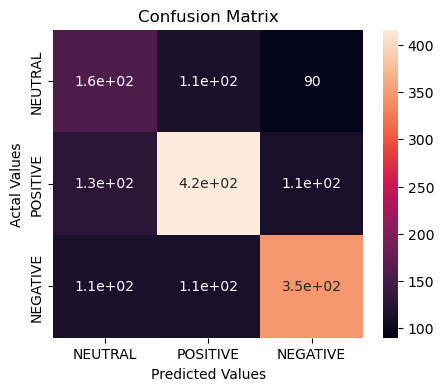

Precision:  50.55
Recall:  57.94
F1 score:  54.0
Accuracy: 0.579


In [1]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import gensim
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

def RecallPrecisionFScore( y_test, pred ):

  arr = confusion_matrix(y_test, pred)

  fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
  fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
  tp = arr[0][0] + arr[1][1] + arr[2][2]
  
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*precision*recall )/(precision+recall) 

  print( "Precision: ", float('{0:.2f}'.format(precision*100)) )
  print( "Recall: ", float('{0:.2f}'.format(recall*100)) )
  print( "F1 score: ", float('{0:.2f}'.format(f1*100)) )

  return float('{0:.2f}'.format(precision*100)), float('{0:.2f}'.format(recall*100)), float('{0:.2f}'.format(f1*100))

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):

    # determine the dimensionality of vectors
    v = self.word_vectors.get_word_vector('আমি')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_word_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

def feature_based( df_train, df_test, c, x1, y1, gram ):

  X_train = df_train["Data"]
  X_test = df_test["Data"]

  y_train = df_train["Label"]
  y_test = df_test["Label"]

  tfidf_vect_ngram = TfidfVectorizer(analyzer = gram, ngram_range=(x1,y1), tokenizer=lambda x: x.split())
  tfidf_vect_ngram.fit(X_train)
  #feature_names = tfidf_vect_ngram.get_feature_names()
  xtrain =  tfidf_vect_ngram.transform(X_train) 
  xtest =  tfidf_vect_ngram.transform(X_test)

  #linear = LinearSVC(C = c, penalty='l2', loss = 'squared_hinge')
  #linear.fit(xtrain, y_train)
  #pred = linear.predict(xtest)
  dt = DecisionTreeClassifier(random_state=128)
  df = tree.DecisionTreeClassifier()
  dt.fit(xtrain, y_train)
  pred = dt.predict(xtest)

  arr = confusion_matrix(y_test, pred)
  cm_df = pd.DataFrame(arr,
                     index = ['NEUTRAL','POSITIVE','NEGATIVE'], 
                     columns =['NEUTRAL','POSITIVE','NEGATIVE'])
    
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  RecallPrecisionFScore( y_test, pred )
  print('Accuracy: %.3f' % accuracy_score(y_test,pred))
  

if __name__ == '__main__':
  df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv" )
  df_val =  pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv" )
  df_test = pd.read_csv( "/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv" )
  print("For unigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 1, gram = "word" )
  print("For Bigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 2, gram = "word" )
  print("For Trigram:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 3, gram = "word" )
  print("For Unigram+Bigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 2, gram = "word" )
  print("For Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 3, gram = "word" )
  print("For Unigram+Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 1, y1 = 3, gram = "word" )

For unigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


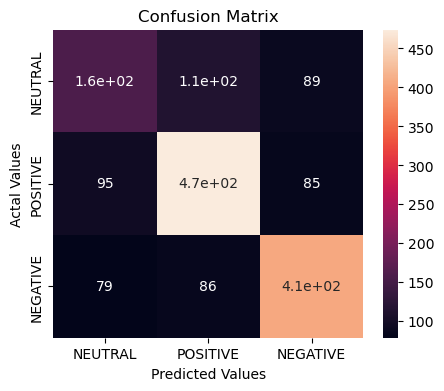

Precision:  54.31
Recall:  65.51
F1 score:  59.39
Accuracy: 0.655
For Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


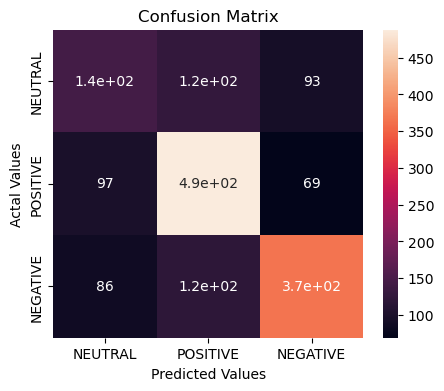

Precision:  53.43
Recall:  62.86
F1 score:  57.76
Accuracy: 0.629
For Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


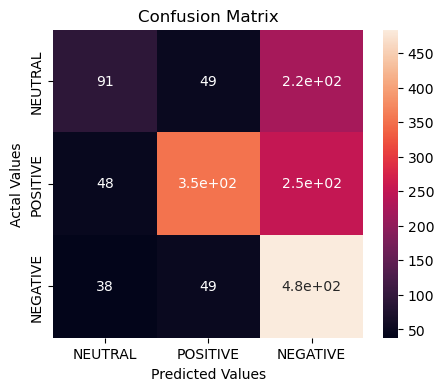

Precision:  45.62
Recall:  58.45
F1 score:  51.24
Accuracy: 0.584
For Unigram+Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


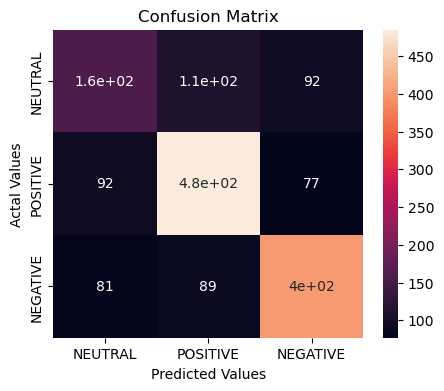

Precision:  54.83
Recall:  65.89
F1 score:  59.85
Accuracy: 0.659
For Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


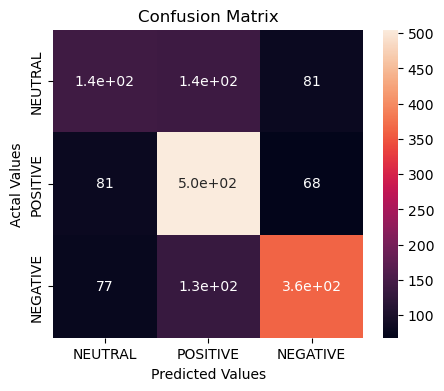

Precision:  53.87
Recall:  63.56
F1 score:  58.32
Accuracy: 0.636
For Unigram+Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


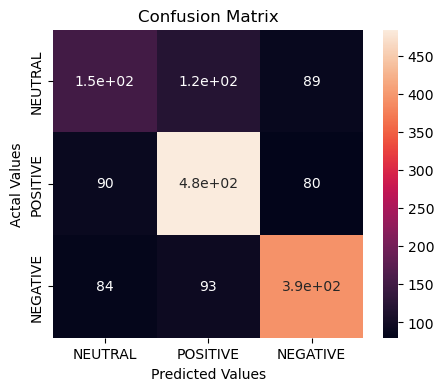

Precision:  54.27
Recall:  64.88
F1 score:  59.1
Accuracy: 0.649


In [5]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import gensim
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def RecallPrecisionFScore( y_test, pred ):

  arr = confusion_matrix(y_test, pred)

  fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
  fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
  tp = arr[0][0] + arr[1][1] + arr[2][2]
  
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*precision*recall )/(precision+recall) 

  print( "Precision: ", float('{0:.2f}'.format(precision*100)) )
  print( "Recall: ", float('{0:.2f}'.format(recall*100)) )
  print( "F1 score: ", float('{0:.2f}'.format(f1*100)) )

  return float('{0:.2f}'.format(precision*100)), float('{0:.2f}'.format(recall*100)), float('{0:.2f}'.format(f1*100))

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):

    # determine the dimensionality of vectors
    v = self.word_vectors.get_word_vector('আমি')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_word_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

def feature_based( df_train, df_test, c, x1, y1, gram ):

  X_train = df_train["Data"]
  X_test = df_test["Data"]

  y_train = df_train["Label"]
  y_test = df_test["Label"]

  tfidf_vect_ngram = TfidfVectorizer(analyzer = gram, ngram_range=(x1,y1), tokenizer=lambda x: x.split())
  tfidf_vect_ngram.fit(X_train)
  #feature_names = tfidf_vect_ngram.get_feature_names()
  xtrain =  tfidf_vect_ngram.transform(X_train) 
  xtest =  tfidf_vect_ngram.transform(X_test)

  #linear = LinearSVC(C = c, penalty='l2', loss = 'squared_hinge')
  #linear.fit(xtrain, y_train)
  #pred = linear.predict(xtest)
  k = 5
  weights = 'distance'
  clf = KNeighborsClassifier(n_neighbors=k, weights=weights)
  # fit the model to the data and labels
  clf.fit(xtrain, y_train)
  pred = clf.predict(xtest)
  arr = confusion_matrix(y_test, pred)
  cm_df = pd.DataFrame(arr,
                     index = ['NEUTRAL','POSITIVE','NEGATIVE'], 
                     columns =['NEUTRAL','POSITIVE','NEGATIVE'])
    
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  RecallPrecisionFScore( y_test, pred )
  print('Accuracy: %.3f' % accuracy_score(y_test,pred))
  

if __name__ == '__main__':
  df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv" )
  df_val =  pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv" )
  df_test = pd.read_csv( "/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv" )
  print("For unigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 1, gram = "word" )
  print("For Bigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 2, gram = "word" )
  print("For Trigram:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 3, gram = "word" )
  print("For Unigram+Bigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 2, gram = "word" )
  print("For Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 3, gram = "word" )
  print("For Unigram+Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 1, y1 = 3, gram = "word" )

For unigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


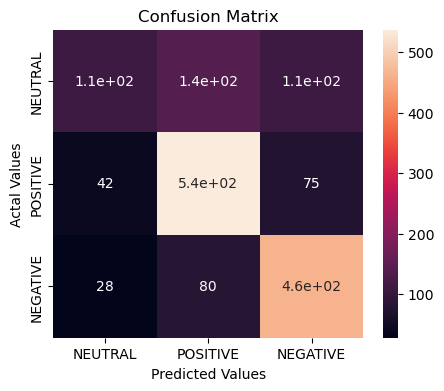

Precision:  54.92
Recall:  69.99
F1 score:  61.55
Accuracy: 0.700
For Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


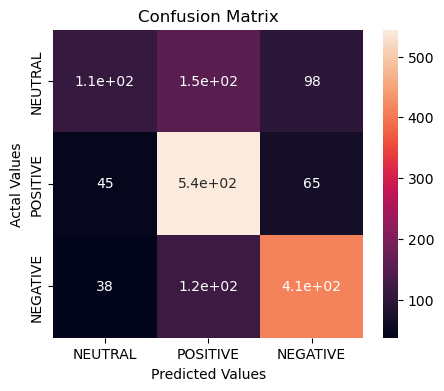

Precision:  54.41
Recall:  67.28
F1 score:  60.16
Accuracy: 0.673
For Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


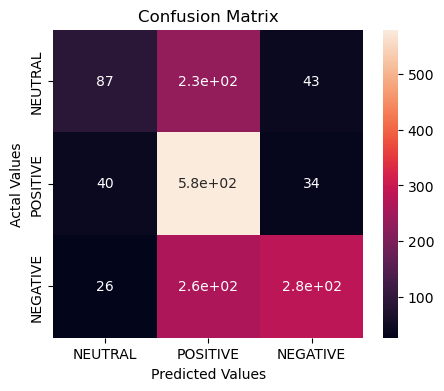

Precision:  51.52
Recall:  59.84
F1 score:  55.37
Accuracy: 0.598
For Unigram+Bigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


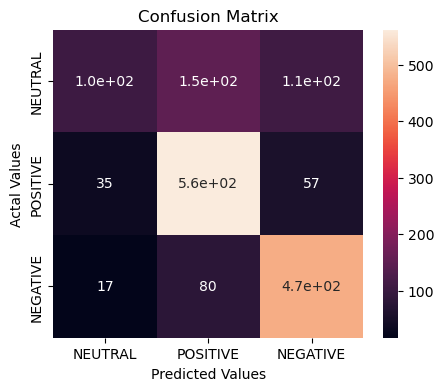

Precision:  55.85
Recall:  71.94
F1 score:  62.88
Accuracy: 0.719
For Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


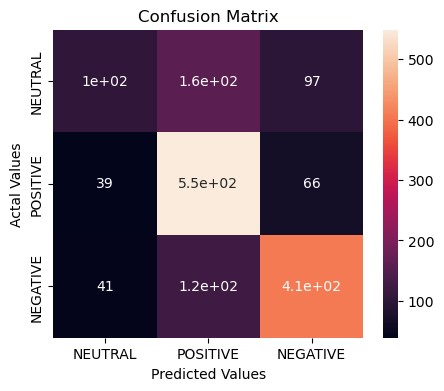

Precision:  54.3
Recall:  66.83
F1 score:  59.92
Accuracy: 0.668
For Unigram+Bigram+Trigram:


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


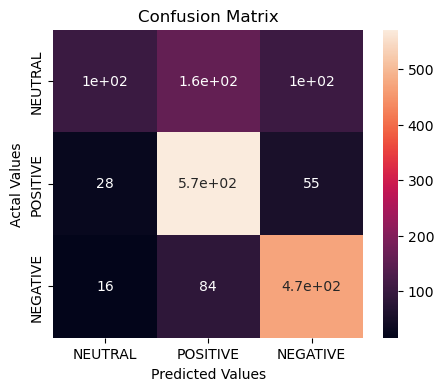

Precision:  56.0
Recall:  72.07
F1 score:  63.03
Accuracy: 0.721


In [17]:
import os
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import gensim
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

def RecallPrecisionFScore( y_test, pred ):

  arr = confusion_matrix(y_test, pred)

  fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
  fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
  tp = arr[0][0] + arr[1][1] + arr[2][2]
  
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*precision*recall )/(precision+recall) 

  print( "Precision: ", float('{0:.2f}'.format(precision*100)) )
  print( "Recall: ", float('{0:.2f}'.format(recall*100)) )
  print( "F1 score: ", float('{0:.2f}'.format(f1*100)) )

  return float('{0:.2f}'.format(precision*100)), float('{0:.2f}'.format(recall*100)), float('{0:.2f}'.format(f1*100))

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):

    # determine the dimensionality of vectors
    v = self.word_vectors.get_word_vector('আমি')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_word_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

def feature_based( df_train, df_test, c, x1, y1, gram ):

  X_train = df_train["Data"]
  X_test = df_test["Data"]

  y_train = df_train["Label"]
  y_test = df_test["Label"]

  tfidf_vect_ngram = TfidfVectorizer(analyzer = gram, ngram_range=(x1,y1), tokenizer=lambda x: x.split())
  tfidf_vect_ngram.fit(X_train)
  #feature_names = tfidf_vect_ngram.get_feature_names()
  xtrain =  tfidf_vect_ngram.transform(X_train) 
  xtest =  tfidf_vect_ngram.transform(X_test)

  #linear = LinearSVC(C = c, penalty='l2', loss = 'squared_hinge')
  #linear.fit(xtrain, y_train)
  #pred = linear.predict(xtest)
  classifier = MultinomialNB(alpha=0.1)
  classifier.fit(xtrain, y_train)
  pred = classifier.predict(xtest)
  arr = confusion_matrix(y_test, pred)
  cm_df = pd.DataFrame(arr,
                     index = ['NEUTRAL','POSITIVE','NEGATIVE'], 
                     columns =['NEUTRAL','POSITIVE','NEGATIVE'])
    
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  RecallPrecisionFScore( y_test, pred )
  print('Accuracy: %.3f' % accuracy_score(y_test,pred))
  

if __name__ == '__main__':
  df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv" )
  df_val =  pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv" )
  df_test = pd.read_csv( "/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv" )
  print("For unigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 1, gram = "word" )
  print("For Bigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 2, gram = "word" )
  print("For Trigram:")
  feature_based(df_train, df_test, c = 1, x1 = 3, y1 = 3, gram = "word" )
  print("For Unigram+Bigram:")
  feature_based(df_train, df_test, c = 1, x1 = 1, y1 = 2, gram = "word" )
  print("For Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 2, y1 = 3, gram = "word" )
  print("For Unigram+Bigram+Trigram:")
  feature_based(df_train, df_test, c = 10, x1 = 1, y1 = 3, gram = "word" )

In [4]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import tensorflow as tf

import re
import numpy as np
import time
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# %matplotlib inline
import itertools
import csv
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import spacy
from sklearn.manifold import TSNE

from gensim.models.phrases import Phrases, Phraser
import logging
import gensim
from gensim.models import Word2Vec
import multiprocessing
# from gensim.models.wrappers import FastText
from gensim.models import fasttext as ftext
from gensim.test.utils import datapath
from torch.utils.data import Dataset, DataLoader


from torch.autograd import Variable
from torch.nn.parameter import Parameter
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
import random


import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
from torch.nn.parameter import Parameter

random.seed(50)


# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset

# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        # self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        self.length = [ len(x) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)




class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):

        print(type(self.sentences))
        self.vocab.update(self.sentences)
            
        # sort the vocab
        self.vocab = sorted(self.vocab)
#         print(self.vocab)
        

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            if word == self.vocab[-1]:
                self.word2idx[word] = 0
            else:
                self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word


class LSTM_Attn_Sentiment(torch.nn.Module):
    def __init__(self,  vocab_size, embedding_matrix, embedding_dim, batch_size, output_size, hidden_size, n_layers, bidirectional,
                  dropout, NUM_FILTERS =10, window_sizes=(1,2,3,5)):
      super(LSTM_Attn_Sentiment, self).__init__()
      
      """
      Arguments
      ---------
      batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
      output_size : 2 = (pos, neg)
      hidden_sie : Size of the hidden_state of the LSTM
      vocab_size : Size of the vocabulary containing unique words
      embedding_length : Embeddding dimension of GloVe word embeddings
      weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
      
      --------
      return : logits, sentence embedding
      """
      
      
      self.batch_size = batch_size
      self.output_size = output_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      

      
      # self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix)) //Pretrained
      self.embedding = nn.Embedding(vocab_size, embedding_dim) 


      self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = n_layers, bidirectional = True,  batch_first = True)

      self.attn = Attention(self.hidden_size*2)
      self.dropout = nn.Dropout(dropout)
      self.softmax = nn.Softmax(dim = 1)
      self.label = nn.Linear(hidden_size*2, output_size)


    def forward(self, input_sentences, batch_size=None):

      """ 
      Parameters
      ----------
      input_sentence: input_sentence of shape = (batch_size, num_sequences)
      batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
      
      Returns
      -------
      Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
      final_output.shape = (batch_size, output_size)
      
      """
      
      input = self.embedding(input_sentences)

      
   
      if batch_size is None:
        h_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size))
        c_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size))
      else:
        h_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size))
        c_0 = Variable(torch.zeros(self.n_layers * 2, self.batch_size, self.hidden_size))
        
      output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0.detach(), c_0.detach())) # final_hidden_state.size() = (1, batch_size, hidden_size) 

      attn_output = self.attn(output)

      attn_output = self.dropout(attn_output)
      
      logits = self.label(attn_output)
      logits = self.softmax(logits)
      
      
      return logits, input, attn_output


class Attention(nn.Module):
    def __init__(self, dimension):
        super(Attention, self).__init__()
        self.wt = Parameter(torch.Tensor(dimension, dimension))
        self.u = nn.Linear(dimension, dimension)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, h):
      

        x = self.u(h)
       
        x = self.softmax(x)

        
        output = x * h

        output = torch.sum(output, dim=1)

        return output
            
            
def max_length(tensor):
    return 50




def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded


def dataset_preprocessing():
    df_test = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv" )
    df_train =  pd.read_csv( "/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv" )
    df_val = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv" )
    dictions = pytorch_embedding(df_train)
    inputs = ConstructVocab(dictions)


   
    input_tensor_train, target_tensor_train, num_emotions, iktu, max_length = converting_to_w2v(df_train,inputs, testy = False)
    input_tensor_val, target_tensor_val, num_emotions, iktu, max_length = converting_to_w2v(df_val, inputs, testy= False)
    input_tensor_test, target_tensor_test, num_emotions, iktu, max_length = converting_to_w2v(df_test, inputs, testy = True)



    ###Split data
    
  

    # Show length
    print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))
    
    
    
    ##Data Loader
    
    TRAIN_BUFFER_SIZE = len(input_tensor_train)
    VAL_BUFFER_SIZE = len(input_tensor_val)
    TEST_BUFFER_SIZE = len(input_tensor_test)
    BATCH_SIZE = 256
    TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
    VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
    TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

    
    vocab_inp_size = len(inputs.word2idx)
    target_size = num_emotions

    
    train_dataset = MyData(input_tensor_train, target_tensor_train)
    val_dataset = MyData(input_tensor_val, target_tensor_val)
    test_dataset = MyData(input_tensor_test, target_tensor_test)

    train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
    val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
    test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                         drop_last=True,
                         shuffle=False)
  



    return train_dataset, val_dataset, test_dataset, input_tensor_train, input_tensor_val, input_tensor_test, weights, vocab_inp_size, inputs, max_length
    

def pytorch_embedding(df):
  vocabs = set()
  corpus = df.Data.to_list()
  for sentences in corpus:
    vocabs.update(sentences.split())

  print(vocabs)
  dict_vocab = {}
  for index, word in enumerate(vocabs):
    
    dict_vocab[word] = index

  return dict_vocab


def converting_to_w2v(data, inputs, testy):
  
  
  ##Taking control of the unknown word
  
  input_tensor1 = []

  for es in data["Data"].values.tolist():
    
    temp = []
    for s in es.split():
      try:
        temp.append(inputs.word2idx[s])
      except:
        temp.append(0)
      temp.append(0)
    
    input_tensor1.append(temp)
  
  
  max_length_inp = max_length(input_tensor1)
  

  
  
  input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor1]


  

  
  ### convert targets to one-hot encoding vectors
  emotions = list(set(data.Label.unique()))
  num_emotions = len(emotions)

  
  
  target_tensor = data.Label.to_numpy()

  return input_tensor, target_tensor, num_emotions, input_tensor1, max_length_inp


def create_model(weights, vocab_size):
  """
  Initializes the model
  Moves to GPU if found any

  Return: the model
  """
  print("vocab_size: ",vocab_size)
  embedding_dim = 300
  dropout = 0.3
  bidirectional = True
  n_layers = 2
  units = 100
  BATCH_SIZE = 256
  target_size = 3

  model = LSTM_Attn_Sentiment(vocab_size, weights, embedding_dim, BATCH_SIZE, target_size, units, n_layers, bidirectional, dropout)

  return model, embedding_dim, units

def accuracy(acc_targ, acc_pred):
    acc_tot = 0
    arr = confusion_matrix(acc_targ, acc_pred)
    for k in range(len(acc_targ)):
        if(acc_targ[k] == acc_pred[k]):
            acc_tot += 1
    
    fp = arr[0][1] + arr[0][2] + arr[1][0] + arr[1][2] + arr[2][1] + arr[2][2]
    fn = arr[1][0] + arr[2][0] + arr[0][1] + arr[2][1] + arr[0][2] + arr[1][2]
    tp = arr[0][0] + arr[1][1] + arr[2][2]
    print("tp: ", tp)
    print("fp: ",fp)
    print("fn: ", fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print("precision: ", round(tp/(tp+fp)*100,2) )
    print("recall: ", round(tp/(tp+fn)*100,2) )
    print("f1: ", round( ((2*precision*recall )/(precision+recall) )*100,2) )

            
    return acc_tot/ len(acc_targ)


def train(model, iterator, optimizer, tot_len, max_length, embedding_dim):
    
    epoch_loss = 0
    
    acc_targ = []
    acc_pred = []
    
    model.train()
    word_embedding = torch.empty(((0,max_length, embedding_dim)))
    
    cnt = 0
    
    for (batch, (inp, targ, lens)) in enumerate(iterator):
        
        cnt += 1
        
        optimizer.zero_grad()
        
        
        predictions, input, sentence_embedding = model(inp)

        word_embedding = torch.cat((word_embedding,input),dim = 0)
        

        criterion = nn.CrossEntropyLoss()
        

        loss = criterion(predictions, targ)

        
        
        

        
        loss.backward()
        
        
        optimizer.step()


        
        epoch_loss += loss.data.item()
        
        acc_targ.extend(targ.tolist())

        acc_pred.extend(torch.max(predictions, 1)[1].tolist())
    

    return epoch_loss / len(iterator), acc_targ, acc_pred, word_embedding



def evaluate(model, iterator, tot_len, embedding_dim, inputs, units):
    
    epoch_loss = 0
    acc_targ = []
    acc_pred = []
    index_tensors = []
    
    model.eval()
    
    for_projection = torch.empty((0,units*2))
    

    sentences = []

    with torch.no_grad():
      for (batch, (inp, targ, lens)) in enumerate(iterator):


            predictions, input, sentence_embedding = model(inp)
           
                 
            for_projection = torch.cat((for_projection,sentence_embedding),dim = 0)
           

            criterion = nn.CrossEntropyLoss()
            
            loss = criterion(predictions, targ)           

            for i in range(inp.size(0)):
           
            
              st = ''

            
              for j in range(inp.size(1)):
                
              
                if(inp.cpu().numpy()[i][j] == 0):
                  st += ' '
                else:
                  st += inputs.idx2word[inp.cpu().numpy()[i][j]]
                  
              
              fin_st = ''
              tired = False
              for char in st:
                if(char == ' ' and tired == False):
                  fin_st += ' '
                  tired = True
                elif(char != ' '):
                  fin_st += char
                  tired = False               

             
              sentences.append(fin_st)

            acc_targ.extend(targ.tolist())
           
            acc_pred.extend(torch.max(predictions, 1)[1].tolist())
            index_tensors.extend(torch.max(predictions, 1)[0].tolist())
           
            

            epoch_loss += loss.data.item()
    
    return epoch_loss / len(iterator), acc_targ, acc_pred, for_projection, index_tensors, sentences


def training_loop(train_dataset, val_dataset, input_tensor_train, input_tensor_val,test_dataset, input_tensor_test, weights, vocab_size, inputs, max_len):
    """
    :return:
    """
    model, embedding_dim, units = create_model(weights, vocab_size)

    optimizer = optim.Adam( model.parameters(), lr=0.01)

    max_epochs = 50

    best_valid_acc = 0


    for epoch in range(max_epochs):

        print('[Epoch %d]' % (epoch + 1))

        train_loss, cnt_targ, cnt_pred, input= train(model, train_dataset, optimizer, len(input_tensor_train), max_len, embedding_dim)
        
        train_acc = accuracy(cnt_targ, cnt_pred)

        val_loss, cnt_targ, cnt_pred, _, index_tensors, _ = evaluate(model, val_dataset, len(input_tensor_val), embedding_dim, inputs, units)
        
        val_acc = accuracy(cnt_targ, cnt_pred)





        print('Training Loss %.5f, Validation Loss %.5f' % (train_loss, val_loss))
        print('Training Accuracy %.5f, Validation Accuracy %.5f' % (train_acc, val_acc) )

        



        writer.add_scalars('Loss', {'Train_Loss':train_loss,
                                'Val_loss':val_loss}, epoch)
        
        writer.add_scalars('Accuracy', {'Train_Acc':train_acc,
                        'Val_Acc':val_acc}, epoch)
        

        
        

        if val_acc > best_valid_acc:
          best_valid_acc = val_acc
          torch.save(model.state_dict(), 'random-model.pt')



        print()



    model.load_state_dict(torch.load('./random-model.pt'))

    
    
    loss, cnt_targ, cnt_pred, sentence_embedding, index_tensors, sentences  = evaluate(model, test_dataset, len(input_tensor_test), embedding_dim, inputs, units)


    print("Test Result")
    result = accuracy(cnt_targ, cnt_pred)
    
    print("Test Accuracy: ", result)
    
    
    loss, cnt_targ, cnt_pred, sentence_embedding, index_tensors, sentences  = evaluate(model, val_dataset, len(input_tensor_val), embedding_dim, inputs, units)
    print("Validation Result")
    result = accuracy(cnt_targ, cnt_pred)
    
    
    print("Val Accuracy: ", result)
    
    

    return model

def test(test_dataset, input_tensor_test, weights):
    model = create_model(weights)

    model.load_state_dict(torch.load('tut6-model.pt'))

    loss, result = evaluate(model, test_dataset, len(input_tensor_test))
    print("Test Accuracy: ", result)

def plot_loss(history):
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title('Loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1.5]);
    plt.savefig('Loss')

def plot_acc(history):
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Acc history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('Accuracy')
    

if __name__ == '__main__':
    writer = SummaryWriter()
    train_dataset, val_dataset, test_dataset, input_tensor_train, input_tensor_val, input_tensor_test, weights, vocabs, inputs, max_length = dataset_preprocessing()
    model = training_loop(train_dataset, val_dataset, input_tensor_train, input_tensor_val, test_dataset, input_tensor_test, weights, vocabs, inputs, max_length)

{'ফ্রাই', 'প্যাকেটের', 'খাদ\u200d্যগলিডেকার্স', 'টুকু', 'লাফালাফি', 'শেরে', 'চেয়ারম্যান', 'থামাতে', 'ড্রিঙ্ক', 'বাকী', '-এর', 'মানুষটারকে', 'বুটান', 'থা\u200cকি', 'বাচনভঙ্গি', 'দত্ত', 'দুনটাই', 'চ', 'গাভী', 'ভলো', 'হাসপতাল', '৩০০', 'র\u200cইল', 'আলাহ', 'ভাফ', 'চুইদা', 'আসেরে', 'বৈধ', 'রয়েল', 'নূররা', 'যানেন', 'গাবিন', 'ছাইড়া', 'ব্যবহারগুলো', 'অ্যাপলের', 'লোভে', 'গেইন', 'দৌড়ে', 'মাদাচুদের', 'প\u200cড়ে\u200cছি', 'পেটে', 'খে\u200cতে', 'ভয়ঙ্কর', 'দেইখেন', 'ছিরে', 'রুচি', 'এটা', 'মাসেই', 'দেখিয়েন', 'বিরিয়ানিটা', 'মধ\u200c্যে', 'আগামি', 'ঢাকাকে', 'কোপ', 'পাপইন্যা', 'উন্নয়ের', 'বাঁচাও', 'সাম্প্রদায়িকতা', 'আহামরির', 'ইমিডিয়েট', 'আসল', 'খাইতা', 'ত\u200cবে', 'জুড়িয়ে', 'মেলানো', 'অন্ডকোষ', 'সাতশ', 'ক্রিয়েট', 'জুম', 'বাটপাড়ি', 'পেইন্টস', 'হোটলের', 'কাবানা', 'বাসায়', 'থাপপর', 'পাঠারা', 'আৱে', 'ইমপ্রেশনস', 'নাচের', 'পরিচর্যা', 'ব্যাবস্তা', 'আচরন', 'গাঁড়ে', 'আনকাবুত', 'প্রখর', 'দারজিলিং', 'সুগন্ধ', 'মিছ্', 'আলদা', 'পল্টন', 'ব্যাটা', 'একান্ত', 'মানিক', 'যদিও', 'পরিবারই', 'বারো', 'নাম্বারটি', 'ঘ্রা

NameError: name 'weights' is not defined